<a href="https://colab.research.google.com/github/Andi-Nov/Probability-Play/blob/master/Notebook/Playing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<i>Probability Trees</i><br>
--

In [9]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz
import copy
from random import random

In [10]:
class MinCut:
  # A representation of an event in a probability tree.
  def __init__(self, root, t=frozenset(), f=frozenset()):
    self._root = root
    self.t = t
    self.f = f

  def __str__(self):

    true_elements = ', '.join([str(id) for id in sorted(self.t)])
    false_elements = ', '.join([str(id) for id in sorted(self.f)])
    return '{true: {' + true_elements + '}, false: {' + false_elements + '}}'

  def __reptr__(self):
    return self.__str__()
    
  def prop(root, statement):
    cond_lst = Node._parse_statements(statement)
    if len(cond_lst) != 1:
      raise Exception('\'prop\' takes one and only one statement.')
      return None
    cond = cond_lst[0]
    return MinCut._prop(root, root, cond)

  def _prop(root, node, cond):
    condvar, condval = cond
    for var, val in node.assign:
      if condvar == var:
        if condval == val:
          return MinCut(root, frozenset([node.id]), frozenset())
        else:
          return MinCut(root, frozenset(), frozenset([node.id]))
    if not node.children:
      msg = 'Node ' + str(node.id) + ': ' \
          + 'min-cut for condition "' + condvar + ' = ' \
          + condval + '" is undefined.'
      raise Exception(msg)
      
    t_set = frozenset()
    f_set = frozenset()
    for child in node.children:
      _, subnode = child
      subcut = MinCut._prop(root, subnode, cond)
      t_set = t_set.union(subcut.t)
      f_set = f_set.union(subcut.f)
      
    cut = MinCut(root, t_set, f_set)
    if not cut.f:
      cut.t = frozenset([node.id])
    elif not cut.t:
      cut.f = frozenset([node.id])

    return cut

  # Negation
  def neg(self):
    return MinCut(self._root, t=self.f, f=self.t)

  def __invert__(self):
    return self.neg()

  # Conjunction
  def conj(root, cut1, cut2):
    return MinCut._conj(root, root, cut1, cut2, False, False)

  def _conj(root, node, cut1, cut2, end1=False, end2=False):
    if (node.id in cut1.f) or (node.id in cut2.f):
      return MinCut(root, frozenset(), frozenset([node.id]))
    if node.id in cut1.t:
      end1 = True
    if node.id in cut2.t:
      end2 = True
    if end1 and end2:
      return MinCut(root, frozenset([node.id]), frozenset())

    # Recursive
    t_set = frozenset()
    f_set = frozenset()
    for _, subnode in node.children:
      subcut = MinCut._conj(root, subnode, cut1, cut2, end1, end2)
      t_set = t_set.union(subcut.t)
      f_set = f_set.union(subcut.f)

    cut = MinCut(root, t_set, f_set)
    if not cut.f:
      cut.t = frozenset([node.id])
    elif not cut.t:
      cut.f = frozenset([node.id])
    return cut

  def __and__(self, operand):
    return MinCut.conj(self._root, self, operand)
    
  def disj(root, cut1, cut2):
    return MinCut.neg(MinCut.conj(root, MinCut.neg(cut1), MinCut.neg(cut2)))

  def __or__(self, operand):
    return MinCut.disj(self._root, self, operand)
    
  def precedes(root, cut_c, cut_e):
    return MinCut._precedes(root, root, cut_c, cut_e, False)

  def _precedes(root, node, cut_c, cut_e, found_c):
    if not found_c:
      if (node.id in cut_e.t or node.id in cut_e.f or node.id in cut_c.f):
        return MinCut(root, frozenset(), frozenset([node.id]))
      if (node.id in cut_c.t):
        found_c = True
    if found_c:
      if (node.id in cut_e.t):
        return MinCut(root, frozenset([node.id]), frozenset())
      if (node.id in cut_e.f):
        return MinCut(root, frozenset(), frozenset([node.id]))
        
    t_set = frozenset()
    f_set = frozenset()
    for _, subnode in node.children:
      subcut = MinCut._precedes(root, subnode, cut_c, cut_e, found_c)
      t_set = t_set.union(subcut.t)
      f_set = f_set.union(subcut.f)
      
    cut = MinCut(root, t_set, f_set)
    if not cut.f:
      cut.t = frozenset([node.id])
    elif not cut.t:
      cut.f = frozenset([node.id])
    return cut

  def __lt__(self, operand):
    return MinCut.precedes(self._root, self, operand)

In [11]:
# Set the critical point!
class Critical:
  # Constructor
  def __init__(self, s=frozenset()):
    self.s = s

  def __str__(self):
    elements = ', '.join([str(id) for id in sorted(self.s)])
    return '{' + elements + '}'

  def __reptr__(self):
    return self.__str__()

  def critical(root, cut):
    _, crit = Critical._critical(root, cut)
    return crit

  def _critical(node, cut):
    
    if node.id in cut.t:
      return (False, Critical(frozenset()))
    if node.id in cut.f:
      return (True, Critical(frozenset()))
      
    s = frozenset()
    for _, subnode in node.children:
      incut, subcrit = Critical._critical(subnode, cut)
      if incut:
        s = s.union(frozenset([node.id]))
      else:
        s = s.union(subcrit.s)

    return (False, Critical(s))

In [13]:
# Node of tree
class Node:
  # Constructor.
  def __init__(self, uid, statements, children=None):
    self.id = uid
    if isinstance(statements, str):
      self.assign = Node._parse_statements(statements)
    else:
      self.assign = statements
      
    if children is None:
      self.children = []
    else:
      self.children = children

  # Parse statements.
  def _parse_statements(statements):
    statement_list = statements.split(',')
    pair_list = [x.split('=') for x in statement_list]
    assign = [(var.strip(), val.strip()) for var, val in pair_list]
    return assign

  # Sample.
  def sample(self):
    return self._sample(dict())

  def _sample(self, smp):
    # Add new assignments.
    newsmp = {var: val for var, val in self.assign}
    smp = dict(smp, **newsmp)

    # Base case.
    if not self.children:
      return smp

    # Recurse.
    rnum = random()
    for child in self.children:
      subprob, subnode = child
      rnum -= subprob
      if rnum <= 0:
        return subnode._sample(smp)
        
    msg = 'Node ' + str(self.id) + ': ' \
      + 'probabilities of transitions do not add up to one.'
    raise Exception(msg)

  # Insert.
  def insert(self, prob, node):
    self.children.append((prob, node))
    
  def prob(self, cut):
    return self._prob(cut, 1.0)

  def _prob(self, cut, prob):
    if self.id in cut.t:
      return prob
    if self.id in cut.f:
      return 0.0

    # Recursive
    probsum = 0.0
    for child in self.children:
      subprob, subnode = child
      resprob = subnode._prob(cut, prob * subprob)
      probsum += resprob

    return probsum

  def rvs(self):
    sts = dict()
    return self._rvs(sts)

  def _rvs(self, sts):
    for var, val in self.assign:
      if not (var in sts):
        sts[var] = list()
      if not (val in sts[var]):
        sts[var].append(val)

    for _, subnode in self.children:
      sts = subnode._rvs(sts)

    return sts

  def _normalize_children(children, probsum, logsum):
    newchildren = None
    if probsum > 0.0:
      newchildren = [
          (subprob / probsum, subnode) for _, subprob, subnode in children
      ]
    else:
      newchildren = [
          (sublog / logsum, subnode) for sublog, _, subnode in children
      ]
    return newchildren
    
  def see(self, cut):
    root = copy.deepcopy(self)
    root._see(cut, 1.0)
    return root

  def _see(self, cut, prob):
    
    if self.id in cut.t:
      newnode = Node(self.id, self.assign)
      return (1.0, prob)
    if self.id in cut.f:
      newnode = Node(self.id, self.assign)
      return (0.0, 0.0)

    newchildren = []
    probsum = 0.0
    logsum = 0.0
    for subprob, subnode in self.children:
      reslog, resprob = subnode._see(cut, prob * subprob)

      newchildren.append((reslog, resprob, subnode))
      logsum += reslog
      probsum += resprob
      
    self.children = Node._normalize_children(newchildren, probsum, logsum)

    return (1.0, probsum)
    
  def do(self, cut):
    root = copy.deepcopy(self)
    root._do(cut)
    return root

  def _do(self, cut):
    if self.id in cut.t:
      return True
    if self.id in cut.f:
      return False
      
    newchildren = []
    probsum = 0.0
    logsum = 0.0
    for subprob, subnode in self.children:
      resdo = subnode._do(cut)

      if resdo:
        newchildren.append((1.0, subprob, subnode))
        probsum += subprob
        logsum += 1.0
      else:
        newchildren.append((0.0, 0.0, subnode))

    # Normalize.
    self.children = Node._normalize_children(newchildren, probsum, logsum)

    return (1.0, probsum)
    
  def cf(self, root_prem, cut_subj):
    root_subj = self.do(cut_subj)
    root_subj._cf(root_prem, cut_subj)
    return root_subj

  def _cf(self, prem, cut):
    
    if self.id in cut.t:
      return True
    if self.id in cut.f:
      return False

    # Recursive
    critical = False

    for child, child_prem in zip(self.children, prem.children):
      (_, subnode) = child
      (_, subnode_prem) = child_prem
      in_do = subnode._cf(subnode_prem, cut)
      if not in_do:
        critical = True
        continue
        
    if not critical:
      self.children = [
          (subprob, subnode)
          for (_, subnode), (subprob, _) in zip(self.children, prem.children)
      ]

    return True

  # Show probability tree
  def show(self, show_id=False, show_prob=False, cut=None, crit=None):
    # Initialize D-graph
    graph_attr = {
        'bgcolor': 'White',
        'rankdir': 'LR',
        'nodesep': '0.1',
        'ranksep': '0.3',
        'sep': '0'
    }
    node_attr = {
        'style': 'rounded',
        'shape': 'box',
        'height': '0.1',
        'width': '0.5',
        'fontsize': '10',
        'margin': '0.1, 0.02'
    }
    edge_attr = {'fontsize': '10'}
    g = graphviz.Digraph(
        'g',
        format='svg',
        graph_attr=graph_attr,
        node_attr=node_attr,
        edge_attr=edge_attr)
    
    return self._show(
        g, 1.0, show_id=show_id, show_prob=show_prob, cut=cut, crit=crit)

  def _show(self, g, prob, show_id=False, show_prob=False, cut=None, crit=None):
    
    labels = [name + ' = ' + value for name, value in self.assign]
    node_label = '\n'.join(labels)
    if show_id:
      node_label = str(self.id) + '\n' + node_label
    if show_prob:
      node_label = node_label + '\np = ' + '{0:.3g}'.format(prob)
      
    attr = {'style': 'filled, rounded', 'fillcolor': 'WhiteSmoke'}
    if not (cut is None):
      if self.id in cut.t:
        attr = {'style': 'filled, rounded', 'fillcolor': 'AquaMarine'}
      elif self.id in cut.f:
        attr = {'style': 'filled, rounded', 'fillcolor': 'LightCoral'}
    if not (crit is None):
      if self.id in crit.s:
        attr = {'style': 'filled, rounded', 'fillcolor': 'Plum'}
    g.node(str(self.id), label=node_label, **attr)
    
    for child in self.children:
      subprob, subnode = child
      subnode._show(
          g,
          prob * subprob,
          show_id=show_id,
          show_prob=show_prob,
          cut=cut,
          crit=crit)
      g.edge(str(self.id), str(subnode.id), label='{0:.3g}'.format(subprob))

    return g

  def find(self, uid):
    if self.id == uid:
      return self

    for child in self.children:
      subprob, subnode = child
      found_node = subnode.find(uid)
      if found_node is not None:
        return found_node

    return None

In [14]:
class PTree:
  def __init__(self):
    self._root = None
    self._count = 0

  def root(self, statements, children=None):
    self._count += 1
    self._root = Node(self._count, statements, children)
    return self._root

  def child(self, prob, statements, children=None):
    self._count += 1
    return (prob, Node(self._count, statements, children))

  def get_root(self):
    return self._root

  def show(self, show_id=False, show_prob=False, cut=None, crit=None):
    return self._root.show(
        show_id=show_id, show_prob=show_prob, cut=cut, crit=crit)

  def rvs(self):
    return self._root.rvs()

  def rv(self, var):
    return [(self.prob(self.prop(var + ' = ' + val)), val)
            for val in self.rvs()[var]]

  def expect(self, var):
    e = 0.0
    for prob, val in self.rv(var):
      e += prob * float(val)
    return e

  def find(self, uid):
    return self._root.find(uid)

  def prop(self, statement):
    return MinCut.prop(self._root, statement)

  def critical(self, cut):
    return Critical.critical(self._root, cut)

  def sample(self):
    return self._root.sample()

  def prob(self, cut):
    return self._root.prob(cut)

  def see(self, cut):
    newptree = PTree()
    newptree._root = self._root.see(cut)
    return newptree

  def do(self, cut):
    newptree = PTree()
    newptree._root = self._root.do(cut)
    return newptree

  def cf(self, tree_prem, cut_subj):
    newptree = PTree()
    newptree._root = self._root.cf(tree_prem._root, cut_subj)
    return newptree

  def fromFunc(func, root_statement=None):
    if not root_statement:
      root_statement = 'O = 1'

    tree = PTree()
    bvars = dict(Node._parse_statements(root_statement))
    tree.root(root_statement, tree._fromFunc(func, bvars))
    return tree

  def _fromFunc(self, func, bvars):
    transition_list = func(bvars)
    if not transition_list:
      return None
    children = []
    for prob, statement in transition_list:
      add_vars = dict(Node._parse_statements(statement))
      new_bvars = {**bvars, **add_vars}
      res = self._fromFunc(func, new_bvars)
      children.append(self.child(prob, statement, res))
    return children

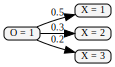

In [15]:
# Create the first tree!

pt = PTree()

pt.root(
    'O = 1',
    [pt.child(0.5, 'X = 1'),
     pt.child(0.3, 'X = 2'),
     pt.child(0.2, 'X = 3')])

display(pt.show())

In [16]:
rvs = pt.rvs()
print('Random variables:', rvs)

pdist = pt.rv('X')
print('P(X) =', pdist)

expect = pt.expect('X')
print('E(X) =', expect)

smp = pt.sample()
print('Sample =', smp)

Random variables: {'O': ['1'], 'X': ['1', '2', '3']}
P(X) = [(0.5, '1'), (0.3, '2'), (0.2, '3')]
E(X) = 1.7000000000000002
Sample = {'O': '1', 'X': '1'}


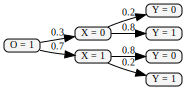

In [17]:
pt = PTree()

pt.root('O = 1', [
    pt.child(0.3, 'X = 0', [
        pt.child(0.2, 'Y = 0'),
        pt.child(0.8, 'Y = 1'),
    ]),
    pt.child(0.7, 'X = 1', [
        pt.child(0.8, 'Y = 0'),
        pt.child(0.2, 'Y = 1'),
    ]),
])

# Display it
display(pt.show())

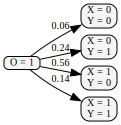

In [18]:
# Set the blank tree
pt = PTree()

pt.root('O = 1', [
    pt.child(0.3 * 0.2, 'X = 0, Y = 0'),
    pt.child(0.3 * 0.8, 'X = 0, Y = 1'),
    pt.child(0.7 * 0.8, 'X = 1, Y = 0'),
    pt.child(0.7 * 0.2, 'X = 1, Y = 1')
])

display(pt.show())

Random variables: {'O': ['1'], 'D': ['0', '1'], 'T': ['0', '1'], 'R': ['0', '1']}


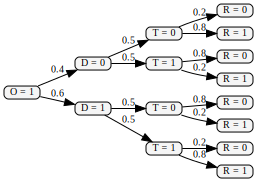

In [20]:
# Bayesian graph?

med = PTree()
med.root('O = 1', [
    med.child(0.4, 'D = 0', [
        med.child(0.5, 'T = 0',
                  [med.child(0.2, 'R = 0'),
                   med.child(0.8, 'R = 1')]),
        med.child(0.5, 'T = 1',
                  [med.child(0.8, 'R = 0'),
                   med.child(0.2, 'R = 1')])
    ]),
    med.child(0.6, 'D = 1', [
        med.child(0.5, 'T = 0',
                  [med.child(0.8, 'R = 0'),
                   med.child(0.2, 'R = 1')]),
        med.child(0.5, 'T = 1',
                  [med.child(0.2, 'R = 0'),
                   med.child(0.8, 'R = 1')])
    ])
])

print('Random variables:', med.rvs())
display(med.show())

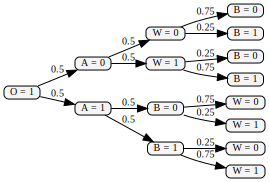

In [21]:
# Weather-barometer worlds

wb = PTree()

wb.root('O = 1', [
    wb.child(0.5, 'A = 0', [
        wb.child(0.5, 'W = 0',
                 [wb.child(0.75, 'B = 0'),
                  wb.child(0.25, 'B = 1')]),
        wb.child(0.5, 'W = 1',
                 [wb.child(0.25, 'B = 0'),
                  wb.child(0.75, 'B = 1')])
    ]),
    wb.child(0.5, 'A = 1', [
        wb.child(0.5, 'B = 0',
                 [wb.child(0.75, 'W = 0'),
                  wb.child(0.25, 'W = 1')]),
        wb.child(0.5, 'B = 1',
                 [wb.child(0.25, 'W = 0'),
                  wb.child(0.75, 'W = 1')])
    ])
])

display(wb.show())

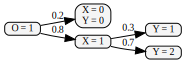

In [22]:
pt = PTree()
pt.root('O = 1', [
    pt.child(0.2, 'X = 0, Y = 0'),
    pt.child(0.8, 'X = 1', [pt.child(0.3, 'Y = 1'),
                            pt.child(0.7, 'Y = 2')])
])

display(pt.show())

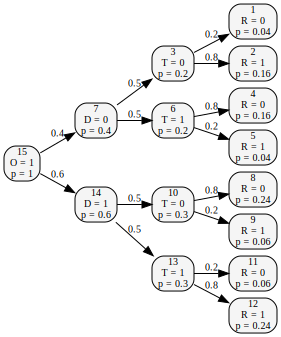

In [23]:
# Displaying additional information
display(med.show(show_prob=True, show_id=True))

{'O': ['1'], 'A': ['0', '1'], 'W': ['0', '1'], 'B': ['0', '1']}
[(0.5, '0'), (0.5, '1')]


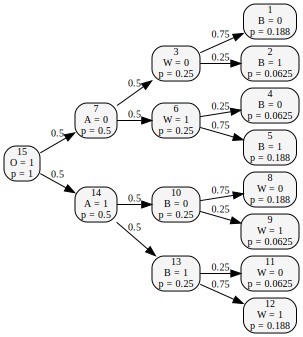

In [24]:
print(wb.rvs())
print(wb.rv('B'))
display(wb.show(show_id=True, show_prob=True))

Type of a cut: <class '__main__.MinCut'>
Min-cut for "R = 1": {true: {2, 5, 9, 12}, false: {1, 4, 8, 11}}


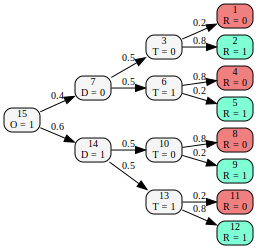

In [27]:
# Propositions and min-cuts

cut = med.prop('R=1')

print('Type of a cut:', type(cut))

print('Min-cut for "R = 1":', cut)

display(med.show(cut=cut, show_id=True))

Min-cut for "T = 0": {true: {3, 10}, false: {6, 13}}


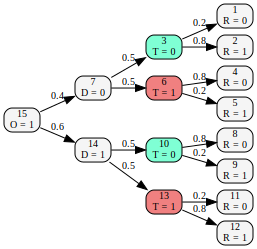

In [28]:
cut = med.prop('T=0')

print('Min-cut for "T = 0":', cut)
display(med.show(cut=cut, show_id=True))

Min-cut for "T = 0": {true: {3, 10}, false: {6, 13}}
Min-cut for "not T = 0": {true: {6, 13}, false: {3, 10}}


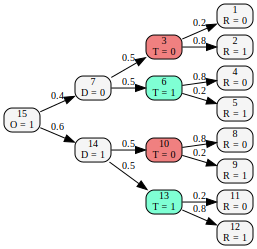

In [31]:
cut = ~med.prop('T = 0')
print('Min-cut for "T = 0":', med.prop('T = 0'))
print('Min-cut for "not T = 0":', ~med.prop('T = 0'))
display(med.show(cut=cut, show_id=True))

Cut for "R = 1":


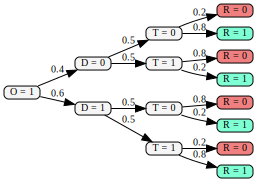

Cut for "T=1":


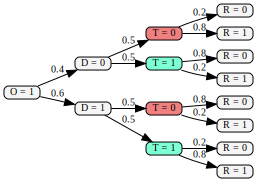

Cut for "T=1 and R=1":


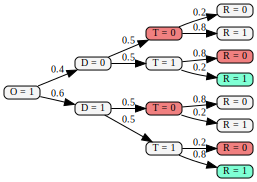

Cut for "T=1 or R=1":


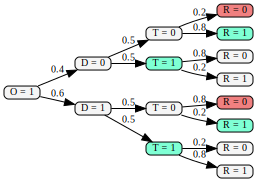

In [34]:
cut1 = med.prop('R=1')
print('Cut for "R = 1":')
display(med.show(cut=cut1))

cut2 = med.prop('T=1')
print('Cut for "T=1":')
display(med.show(cut=cut2))

cut_and = cut1 & cut2
print('Cut for "T=1 and R=1":')
display(med.show(cut=cut_and))

cut_or = cut1 | cut2
print('Cut for "T=1 or R=1":')
display(med.show(cut=cut_or))

Cut for D=1 < R=1:


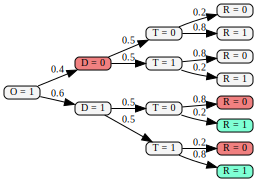

Cut for R=1 < D=1:


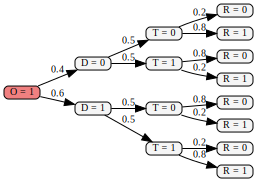

In [37]:
# Precedence relation

cut1 = med.prop('D=1') < med.prop('R=1')
cut2 = med.prop('R=1') < med.prop('D=1')

print('Cut for D=1 < R=1:')
display(med.show(cut=cut1))

print('Cut for R=1 < D=1:')
display(med.show(cut=cut2))

While the root node "O=1" does resolve the event "X=1"
probabilistically, it does not resolve the event logically.


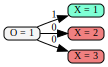

In [39]:
pt = PTree()
pt.root('O = 1',
        [pt.child(1, 'X = 1'),
         pt.child(0, 'X = 2'),
         pt.child(0, 'X = 3')])

cut = pt.prop('X = 1')
print('While the root node "O=1" does resolve the event "X=1"\n' +
      'probabilistically, it does not resolve the event logically.')
display(pt.show(cut=cut))

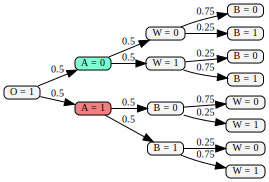

In [40]:
# Min cut!
cut = (wb.prop('W=0') < wb.prop('B=0')) \
    | (wb.prop('W=0') < wb.prop('B=1')) \
    | (wb.prop('W=1') < wb.prop('B=0')) \
    | (wb.prop('W=1') < wb.prop('B=1'))

# Display
display(wb.show(cut=cut))

Try to predict the min-cut and the critical set of the events X=1, Y=1, and Y=0.

Original tree:


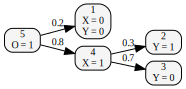

Min-cut and critical set for "X=1":


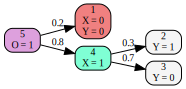

Min-cut and critical set for "Y=1":


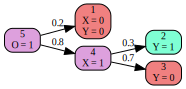

Min-cut and critical set for "Y=0":


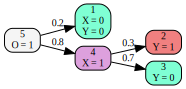

In [41]:
pt = PTree()
pt.root('O = 1', [
    pt.child(0.2, 'X = 0, Y = 0'),
    pt.child(0.8, 'X = 1', [pt.child(0.3, 'Y = 1'),
                            pt.child(0.7, 'Y = 0')])
])

# Original tree.
print('Original tree:')
display(pt.show(show_id=True))

# 'X=1'
cut = pt.prop('X=1')
crit = pt.critical(cut)
print('Min-cut and critical set for "X=1":')
display(pt.show(show_id=True, cut=cut, crit=crit))

# 'Y=1'
cut = pt.prop('Y=1')
crit = pt.critical(cut)
print('Min-cut and critical set for "Y=1":')
display(pt.show(show_id=True, cut=cut, crit=crit))

# 'Y=0'
cut = pt.prop('Y=0')
crit = pt.critical(cut)
print('Min-cut and critical set for "Y=0":')
display(pt.show(show_id=True, cut=cut, crit=crit))

In [42]:
print('P(W) =', wb.rv('W'))
print('P(B) =', wb.rv('B'))

cut = wb.prop('A=1')
print('P(W | A=1) =', wb.see(cut).rv('W'))
print('P(B | A=1) =', wb.see(cut).rv('B'))

cut = wb.prop('W=1')
print('P(W | W=1) =', wb.see(cut).rv('W'))
print('P(B | W=1) =', wb.see(cut).rv('B'))

P(W) = [(0.5, '0'), (0.5, '1')]
P(B) = [(0.5, '0'), (0.5, '1')]
P(W | A=1) = [(0.5, '0'), (0.5, '1')]
P(B | A=1) = [(0.5, '0'), (0.5, '1')]
P(W | W=1) = [(0.0, '0'), (1.0, '1')]
P(B | W=1) = [(0.25, '0'), (0.75, '1')]


Original:


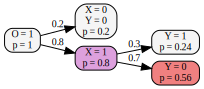

Condition on "Y=1":


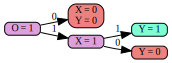

Intervention on "Y<-1":


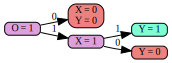

Condition on "Y = 0":


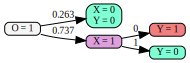

Intervention on "Y <- 0":


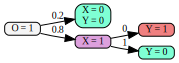

In [45]:
pt = PTree()
pt.root('O = 1', [
    pt.child(0.2, 'X = 0, Y = 0'),
    pt.child(0.8, 'X = 1', [pt.child(0.3, 'Y = 1'),
                            pt.child(0.7, 'Y = 0')])
])

print('Original:')
display(pt.show(show_prob=True, cut=cut, crit=crit))

# 'Y=1'
cut = pt.prop('Y = 1')
crit = pt.critical(cut)
pt_see = pt.see(cut)
pt_do = pt.do(cut)
print('Condition on "Y=1":')
display(pt_see.show(cut=cut, crit=crit))
print('Intervention on "Y<-1":')
display(pt_do.show(cut=cut, crit=crit))

# 'Y=0'
cut = pt.prop('Y = 0')
crit = pt.critical(cut)
pt_see = pt.see(cut)
pt_do = pt.do(cut)
print('Condition on "Y = 0":')
display(pt_see.show(cut=cut, crit=crit))
print('Intervention on "Y <- 0":')
display(pt_do.show(cut=cut, crit=crit))

Original tree:
P(D = 1) = 0.6
P(T = 1) = 0.5
P(R = 1) = 0.5


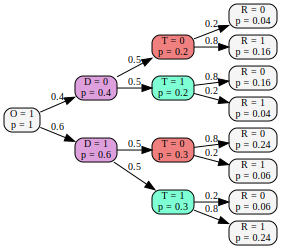

Tree after intervening on "T <- 1":
P(D = 1 | T <- 1) = 0.6
P(T = 1 | T <- 1) = 1.0
P(R = 1 | T <- 1) = 0.56


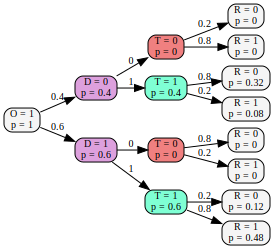

In [47]:
# Min cuts!

cut_dis = med.prop('D = 1')
cut_arg = med.prop('R = 1')
cut_do = med.prop('T = 1')

crit_do = med.critical(cut_do)

med_do = med.do(cut_do)

print('Original tree:')
print('P(D = 1) =', med.prob(cut_dis))
print('P(T = 1) =', med.prob(cut_do))
print('P(R = 1) =', med.prob(cut_arg))
display(med.show(cut=cut_do, show_prob=True, crit=crit_do))

print('Tree after intervening on "T <- 1":')
print('P(D = 1 | T <- 1) =', med_do.prob(cut_dis))
print('P(T = 1 | T <- 1) =', med_do.prob(cut_do))
print('P(R = 1 | T <- 1) =', med_do.prob(cut_arg))
display(med_do.show(cut=cut_do, show_prob=True, crit=crit_do))

Before the intervention:


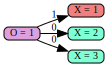

After the invention on "not X <- 1":


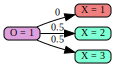

In [49]:
pt = PTree()
pt.root(
    'O = 1',
    [pt.child(1.0, 'X = 1'),
     pt.child(0.0, 'X = 2'),
     pt.child(0.0, 'X = 3')])

cut = ~pt.prop('X = 1')
crit = pt.critical(cut)

pt_do = pt.do(cut)

print('Before the intervention:')
display(pt.show(cut=cut, crit=crit))
print('After the invention on "not X <- 1":')
display(pt_do.show(cut=cut, crit=crit))